In [1]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np

### 0. Dataset

Referenced from:
https://www.kaggle.com/mimbres/neural-audio-fingerprint

### 1. Audio pre-processing


#### Loading audio files

In [2]:
song_file = "audio/song_original.wav"
recording_file = "audio/song_recording.wav"

In [3]:
song, sr = librosa.load(song_file)
recording, _ = librosa.load(recording_file)

In [4]:
recording = recording[19646:]

#### Fourier Transform and Spectrogram

In [5]:
FRAME_SIZE = 2048
HOP_LENGTH = 512
plot = True

In [6]:
# Get dB spectrogram out of songs

def get_spectrogram(data, frame_size, hop_length):
    spec = librosa.stft(
        data,
        n_fft=frame_size,
        window='hann',
        hop_length=hop_length
    )
    y_spec = librosa.power_to_db(np.abs(spec) ** 2)
    return y_spec

In [7]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    if plot:
        plt.figure(figsize=(20, 8), facecolor="white")
        librosa.display.specshow(
            data=Y,
            sr=sr,
            hop_length=hop_length,
            x_axis="time",
            y_axis=y_axis
        )
        plt.colorbar(format="%+2.f")
        plt.xlabel('Time', fontsize=18)
        plt.ylabel('Frequency (Hz)', fontsize=18)
    else:
        print("Plot mode disabled")

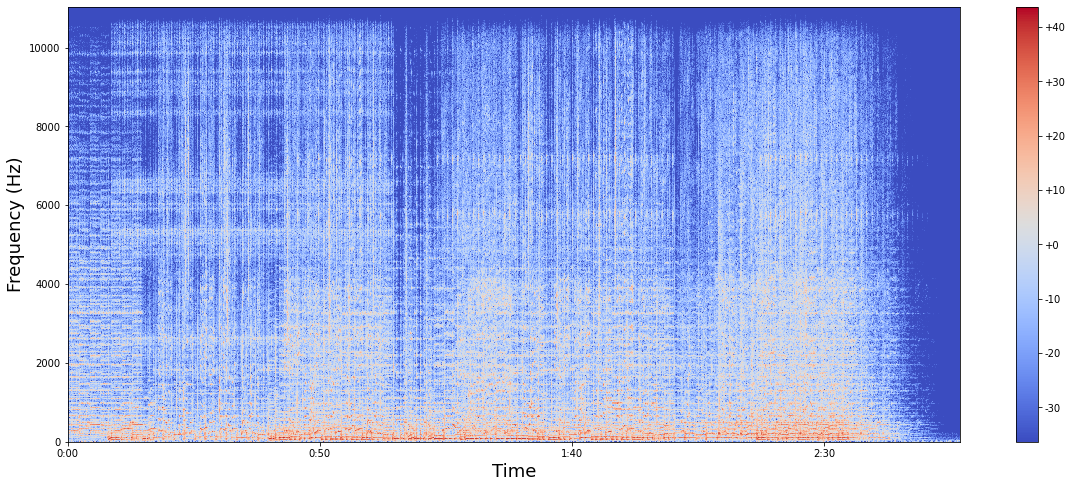

In [8]:
y_spec = get_spectrogram(
    song,
    frame_size=FRAME_SIZE,
    hop_length=HOP_LENGTH)

plot_spectrogram(y_spec, sr, hop_length=HOP_LENGTH)

### 2. Getting peaks in energy amplitude

In [9]:
from skimage.feature import peak_local_max
from skimage import img_as_float
from scipy.ndimage import generate_binary_structure, maximum_filter, binary_erosion, iterate_structure

#### Method 1: Finding local maxima peaks in spectrogram image

Referenced from:

https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=peak%20local%20max#skimage.feature.peak_local_max

In [10]:
def get_peaks(spectrogram, color):
    img = img_as_float(spectrogram)
    coordinates = peak_local_max(
        img, 
        min_distance=20, 
        threshold_rel=0.02
    )
    
    if plot:
        plt.figure(figsize=(20, 8), facecolor="white")
        plt.imshow(img, cmap=plt.cm.gray, origin='lower')
        plt.autoscale(False)
        plt.plot(coordinates[:, 1], coordinates[:, 0], color)
        plt.colorbar()
        plt.xlabel('Time frames', fontsize=18)
        plt.ylabel('Frequency frames', fontsize=18)
        plt.axis('auto')
        plt.show()
    
    return coordinates

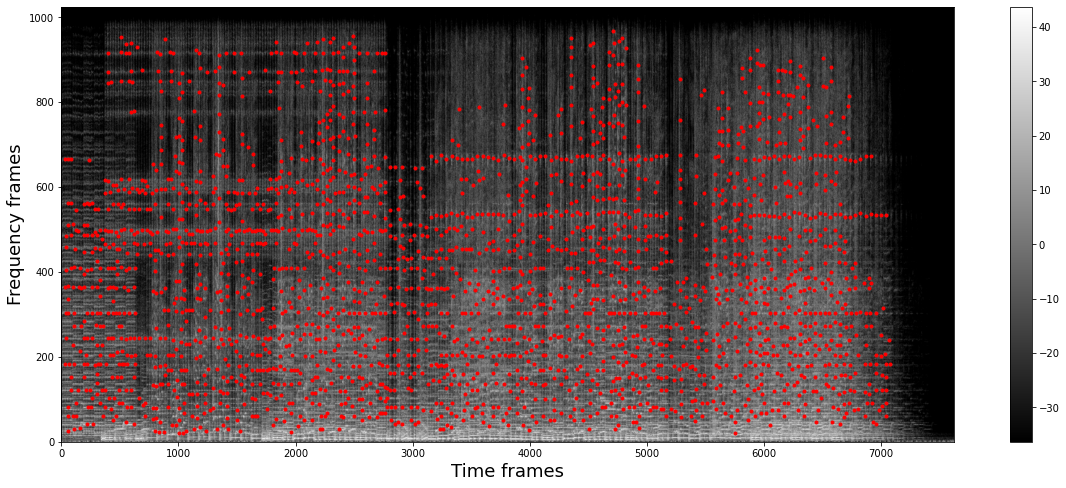

In [11]:
spec = get_spectrogram(song, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
peaks = get_peaks(spec, 'r.')

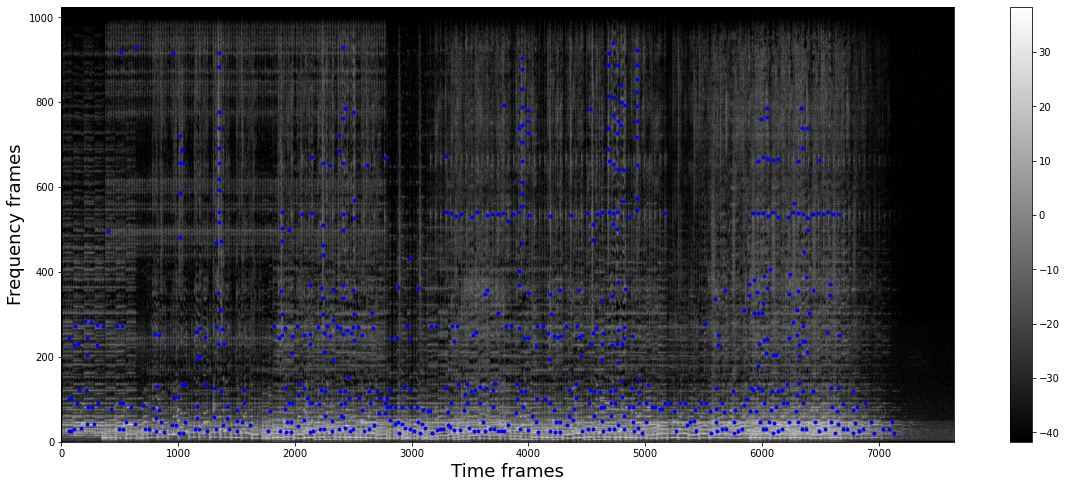

In [12]:
spec_r = get_spectrogram(recording, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
peaks_r = get_peaks(spec_r, 'b.')

In [13]:
peaks.shape

(2520, 2)

In [14]:
peaks_r.shape

(660, 2)

In [15]:
# Storing both values (time, frequency) for song and recording inside a new list

time = [x[1] for x in peaks]
frequency = [x[0] for x in peaks]

time_rec = [x[1] for x in peaks_r]
frequency_rec = [x[0] for x in peaks_r]

filtered_peaks = list(zip(time, frequency))

filtered_peaks_r = list(zip(time_rec, frequency_rec))

In [16]:
# Sorting lists by time value

filtered_peaks.sort(key=lambda tup: tup[0]) 
filtered_peaks_r.sort(key=lambda tup: tup[0])

In [17]:
def check_overlapping_point(list_1, list_2):
    filtered_list_1 = []
    filtered_list_2 = []
    max_t = 10
    max_f = 10
    for i in range(len(list_1)):
        for j in range(len(list_2)):
            dist_t = list_1[i][0] - list_2[j][0]
            dist_f = list_1[i][1] - list_2[j][1]
            if abs(dist_t) < max_t and abs(dist_f) < max_f:
                filtered_list_1.append(list_1[i])
                filtered_list_2.append(list_2[j])
    return filtered_list_1, filtered_list_2

In [18]:
close_points_1, close_points_2 = check_overlapping_point(filtered_peaks, filtered_peaks_r)

In [19]:
close_points_1 = np.array(close_points_1)
close_points_2 = np.array(close_points_2)

In [20]:
def plot_close_points(list_1, list_2):
    plt.figure(figsize=(16, 8), facecolor='white')
    plt.autoscale(False)
    plt.plot(list_1[:, 0], list_1[:, 1], 'r.')
    plt.plot(list_2[:, 0], list_2[:, 1], 'b.')
    plt.xlabel('Time frames', fontsize=18)
    plt.ylabel('Frequency frames', fontsize=18)
    plt.axis('auto')
    plt.show()

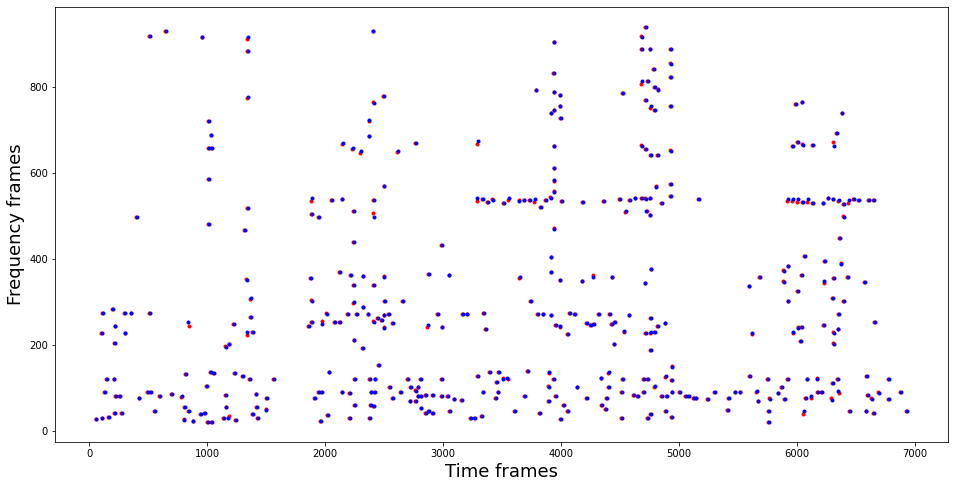

In [21]:
plot_close_points(close_points_1, close_points_2)

In [22]:
# Percentage of common points

recall_prediction = len(close_points_2) / len(filtered_peaks_r)
recall_prediction

0.6545454545454545

#### Method 2: 2D mask maximum filter

Referenced from:

https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array

In [23]:
plot = True

In [24]:
def filter_local_maxima(spectrogram, color):
    area = 20
    structure = generate_binary_structure(2, 1)
    cell = iterate_structure(structure=structure, iterations=area)
    local_max = maximum_filter(spectrogram, footprint=cell)==spectrogram
    background = (spectrogram==False)
    eroded_background = binary_erosion(background, structure=cell)
    detected_peaks = local_max ^ eroded_background

    amplitudes = spectrogram[detected_peaks].flatten()
        # take the time frequency pairs
    freq, t = np.where(detected_peaks)

    # discard all peaks with an amplitude lower than the cutoff
    unfiltered_peaks = zip(t, freq, amplitudes)

    threshold = np.mean(amplitudes) / 20
    print(threshold)

    filtered_peaks = [x for x in unfiltered_peaks if x[2] > threshold]

    # extract time and frequency indicies
    time = [x[0] for x in filtered_peaks]
    frequency = [x[1] for x in filtered_peaks]

    if plot:
        plt.figure(figsize=(20, 8), facecolor="white")
        plt.imshow(spec, cmap=plt.cm.gray, origin='lower')
        plt.autoscale(False)
        plt.plot(time, frequency, color)
        plt.colorbar()
        plt.xlabel('Time frames', fontsize=18)
        plt.ylabel('Frequency frames', fontsize=18)
        plt.axis('auto')
        plt.show()
        
    return list(zip(time, frequency))

-1.7814954757690429


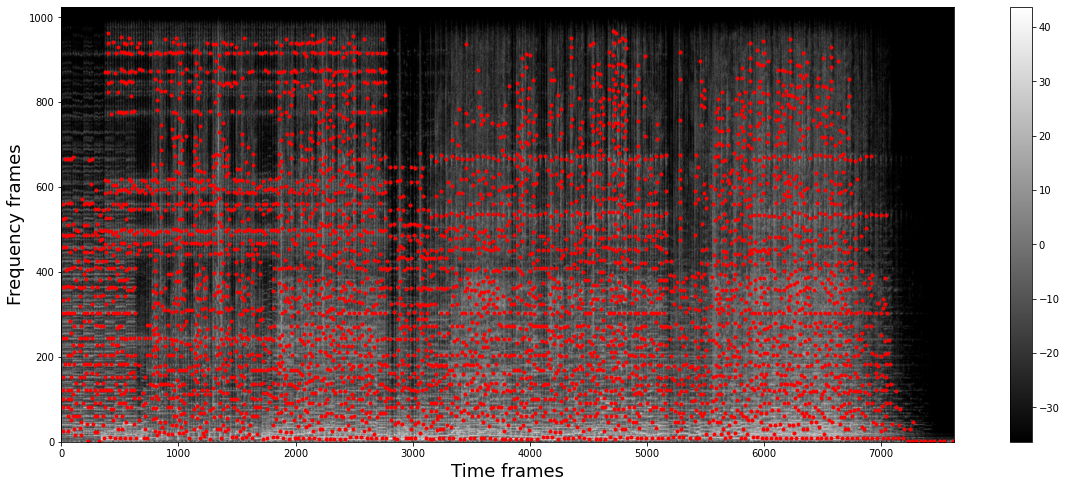

-1.977884292602539


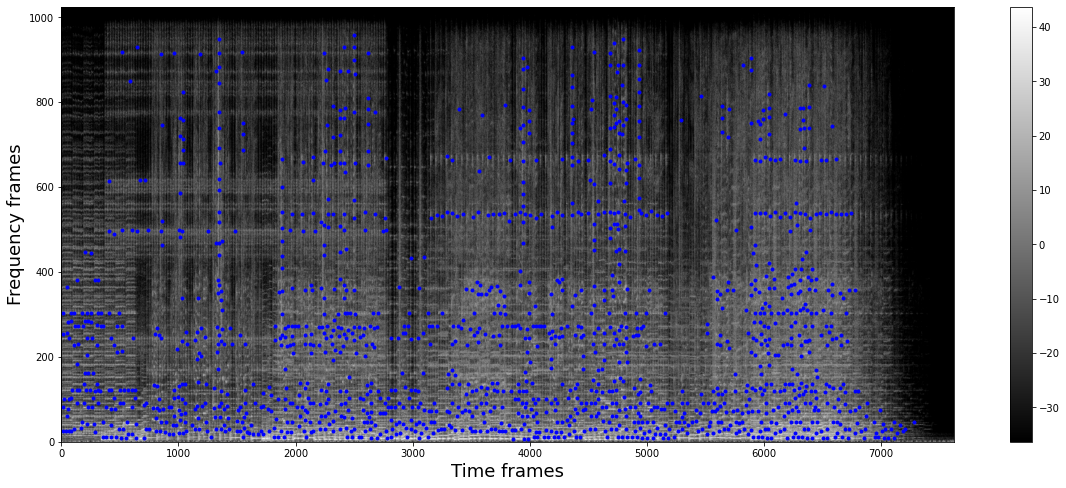

In [25]:
filtered_peaks = filter_local_maxima(spec, 'r.')
filtered_peaks_r = filter_local_maxima(spec_r, 'b.')

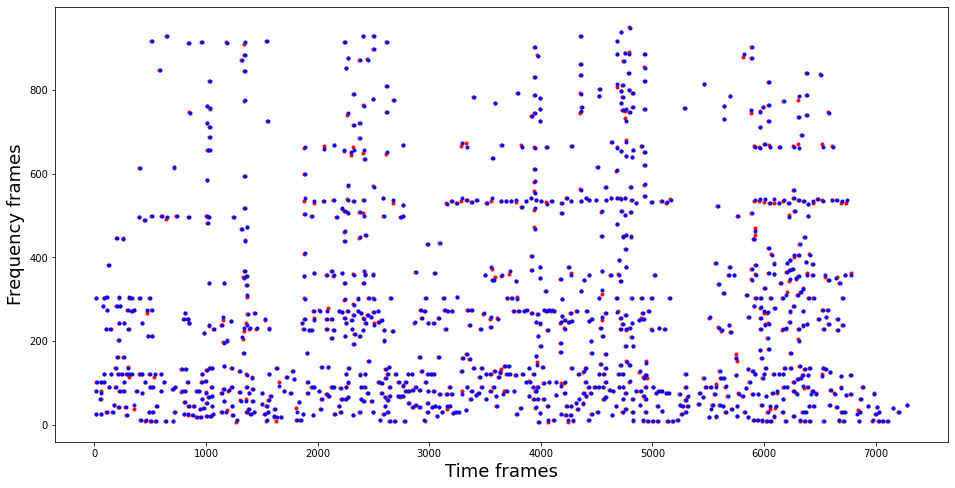

In [26]:
close_points_1, close_points_2 = check_overlapping_point(filtered_peaks, filtered_peaks_r)

close_points_1 = np.array(close_points_1)
close_points_2 = np.array(close_points_2)

plot_close_points(close_points_1, close_points_2)

In [27]:
# Percentage of common points

recall_prediction = len(close_points_2) / len(filtered_peaks_r)
recall_prediction

0.7545271629778671

#### Distribution plots

In [28]:
# Distribution comparison for frequency (2d mask filtered peaks)

def plot_distribution(list_s, list_r):
    array_s = np.array(list_s)
    array_r = np.array(list_r)
    plt.figure(figsize=(16, 8), facecolor='white')
    plt.xlabel('Frequency frames', fontsize=18)
    kwargs = dict(alpha=0.5, bins=100)
    plt.hist(array_s[:,1], **kwargs, color='r', label='Song')
    plt.hist(array_r[:,1], **kwargs, color='b', label='Recording')
    plt.legend()
    plt.show()

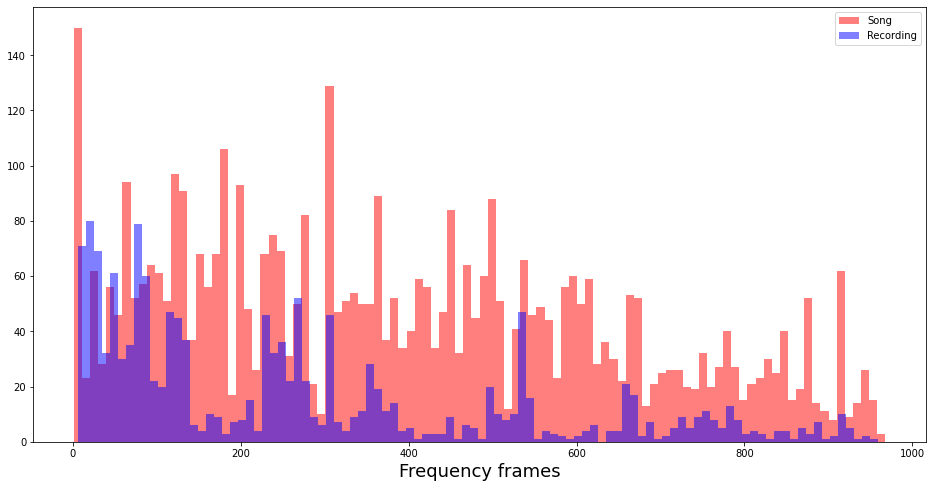

In [29]:
plot_distribution(filtered_peaks, filtered_peaks_r)

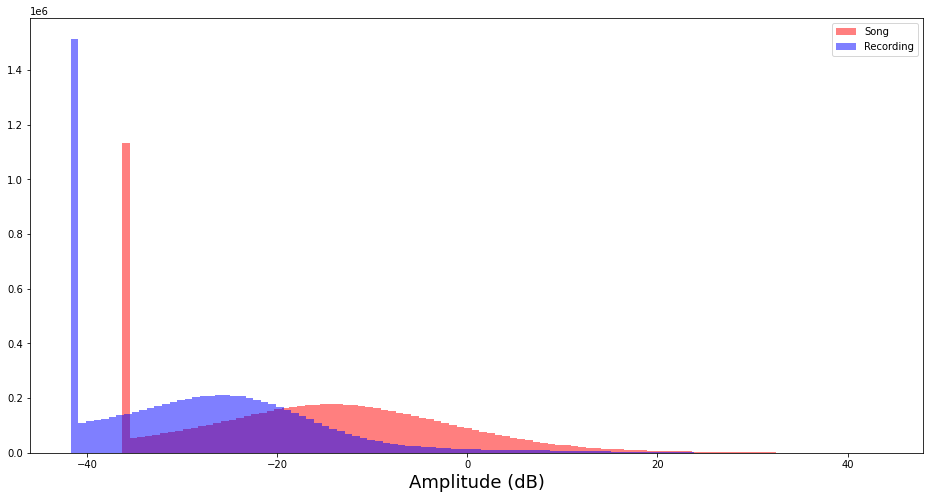

In [30]:
# Distribution comparison for decibel amplitude (full spectrograms)

amplitudes_s = np.expand_dims(spec.flatten(), axis=1)
amplitudes_r = np.expand_dims(spec_r.flatten(), axis=1)

plt.figure(figsize=(16, 8), facecolor='white')
plt.xlabel('Amplitude (dB)', fontsize=18)
kwargs = dict(alpha=0.5, bins=100)
plt.hist(amplitudes_s[:,0], **kwargs, color='r', label='Song')
plt.hist(amplitudes_r[:,0], **kwargs, color='b', label='Recording')
plt.legend()
plt.show()